In [1]:
import pandas as pd

hate_stA_train = pd.read_csv("hate_stA_train.csv")
nohate_stA_train = pd.read_csv("nohate_stA_train.csv")
stA_eval = pd.read_csv("stA_eval.csv")
stA_test = pd.read_csv("stA_test.csv")
eval_subtaskA = pd.read_csv("eval_subtaskA.csv")

def labeler(sample_id, df):
    for column, row in df.iterrows():
        if str(row['index']) == str(sample_id):
            a = int(row['Label'])
            if a == 1:
                return 'hate speech'
            else:
                return 'no hate speech'
    print("Function failed")

training_data = pd.DataFrame(columns=['Sample', 'Text', 'Label'])
hate = 'hate speech' #1
no_hate = 'no hate speech' #0
count = 1
for column, row in stA_eval.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_EvalData/subtaskA/","").replace(".jpg","")
    sample_text = row['text']
    training_data.loc[count] = [sample_id, sample_text, labeler(sample_id, eval_subtaskA)]
    count+=1
for column, row in hate_stA_train.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TrainData/subTaskA/Hate Speech/","").replace(".jpg","")
    sample_text = row['text']
    training_data.loc[count] = [sample_id, sample_text, hate]
    count+=1
for column, row in nohate_stA_train.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TrainData/subTaskA/No Hate Speech/","").replace(".jpg","")
    sample_text = row['text']
    training_data.loc[count] = [sample_id, sample_text, no_hate]
    count+=1
    
print(training_data)

     Sample                                               Text           Label
1     10087  TRUTH BY TEXAS 2019 REPUBLICAN PRESIDENT DONAL...     hate speech
2     10113  Putin stressing tf out after hearing that some...     hate speech
3     10203  Ip Interference in Ukraine move would lead to ...  no hate speech
4     10256  9:32 Carolina Forward Thread @ForwardCarolina ...  no hate speech
5     10270  THAT'S NOT WHAT 'FUCK PUTIN' MEANS! SEE? EVERY...     hate speech
...     ...                                                ...             ...
4039  99632  PROTESTORS AROUND THE WORLD RALLY IN SUPPORT O...  no hate speech
4040  99658  RT LIVE Q 3 Mar, 2022 08:31 / Home / Russia & ...  no hate speech
4041  99773  raging_eve Costa Mesa couple barely escape Ukr...  no hate speech
4042  99882  Sign in Contribute The. Guardian For 200 years...  no hate speech
4043  99927  Rob Lee @RALee85 Colonel Alexey Gorobets, the ...  no hate speech

[4043 rows x 3 columns]


In [2]:
test_data = pd.DataFrame(columns=['Sample', 'Text'])
count = 1
for column, row in stA_test.iterrows():
    sample_id = row['filename'].replace("/content/drive/MyDrive/CASE2023_Task4/CASE2023_TASK4_TestData/subtaskA/","").replace(".jpg","")
    sample_text = row['text']
    test_data.loc[count] = [sample_id, sample_text]
    count+=1
    
print(test_data)

    Sample                                               Text
1    10113    When you keep all the good rations for yourself
2    10165  Media 9:28 1 Tucker Carlson, downplaying Russi...
3    10287  Andreeva Bay nuclear waste storage Bolshaya Lo...
4    10443  So many electricians in the Ukraine but no ele...
5    10532  Daily Mail MORE STORIES Q Russia has fired 'ab...
..     ...                                                ...
439  99353   UKRAINIAN RESISTANCE TO RUSSIA imgflip.com A30 $
440  99743  Patricia Arquette @PattyArquette Well for Lord...
441  99744  4:19 1 Amazon's response to the situation in U...
442  99764  Fox News just asked Trump what he'd do differe...
443  99828  ALL I SAID WAS... NO CHANCE OF WAR IN UKRAINE ...

[443 rows x 2 columns]


hate speech       2185
no hate speech    1858
Name: Label, dtype: int64


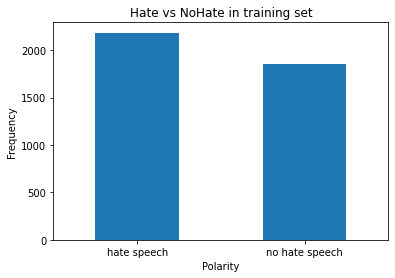

In [3]:
import matplotlib.pyplot as plt

def harry_plotter(df,string, strang):
    frequencies = df[string].value_counts()
    print(frequencies)
    ax = frequencies.plot(kind='bar')
    ax.set_xlabel('Polarity')
    ax.set_ylabel('Frequency')
    ax.set_title(strang)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
harry_plotter(training_data, "Label", "Hate vs NoHate in training set")
#harry_plotter(test_data, "Label", "Hate vs NoHate in test set")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 32)            640032    
                                                                 
 conv1d_8 (Conv1D)           (None, 38, 128)           12416     
                                                                 
 conv1d_9 (Conv1D)           (None, 36, 64)            24640     
                                                                 
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                73760     
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 750,914
Trainable params: 750,914
Non-tr

C:\Users\BORSH\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


102/102 [==============================] - 12s 68ms/step - loss: 0.7790 - categorical_accuracy: 0.6163 - val_loss: 0.6221 - val_categorical_accuracy: 0.7108
Epoch 2/10
102/102 [==============================] - 7s 67ms/step - loss: 0.4998 - categorical_accuracy: 0.8055 - val_loss: 0.6291 - val_categorical_accuracy: 0.7379
Epoch 3/10
102/102 [==============================] - 6s 60ms/step - loss: 0.2823 - categorical_accuracy: 0.9212 - val_loss: 0.7731 - val_categorical_accuracy: 0.7318
Epoch 4/10
102/102 [==============================] - 8s 75ms/step - loss: 0.1615 - categorical_accuracy: 0.9706 - val_loss: 1.0612 - val_categorical_accuracy: 0.7268
Epoch 5/10
102/102 [==============================] - 6s 63ms/step - loss: 0.1282 - categorical_accuracy: 0.9833 - val_loss: 1.0829 - val_categorical_accuracy: 0.7194
Epoch 6/10
102/102 [==============================] - 7s 71ms/step - loss: 0.1071 - categorical_accuracy: 0.9898 - val_loss: 1.3208 - val_categorical_accuracy: 0.7132
Epoch 7/

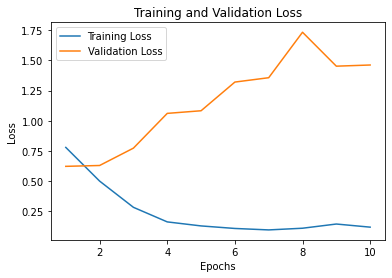

'\n# Train the model\n\nfor epoch in range(epochs):\n    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=1, batch_size=32)\n    \n    # Calculate F1 score on the training set\n    train_predictions = model.predict(train_data)\n    train_predictions = np.argmax(train_predictions, axis=1)\n    train_true_labels = np.argmax(train_labels, axis=1)\n    train_f1 = f1_score(train_true_labels, train_predictions, average=\'macro\')\n    print(f"Epoch {epoch+1} - Train F1 score: {train_f1}")\n'

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import regularizers

max_features = 20000
embedding_dim = 32
sequence_length = 40

# Assuming you have a pandas DataFrame with 'text' and 'label' columns for training and test sets
train_df = training_data

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['Text'])

# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train_df['Text'])

# Pad sequences to a fixed length
train_data = pad_sequences(train_sequences, maxlen=sequence_length)

# Convert labels to one-hot encoding
train_labels = pd.get_dummies(train_df['Label']).values

# Split the training set into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, embedding_dim, input_length=sequence_length,
                                    embeddings_regularizer=regularizers.l2(0.0005)))

model.add(tf.keras.layers.Conv1D(128, 3, activation='relu',
                                 kernel_regularizer=regularizers.l2(0.0005),
                                 bias_regularizer=regularizers.l2(0.0005)))

# Add a second Conv1D layer
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu',
                                 kernel_regularizer=regularizers.l2(0.0005),
                                 bias_regularizer=regularizers.l2(0.0005)))

model.add(tf.keras.layers.Flatten())

# Add a Dense layer
model.add(tf.keras.layers.Dense(32, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))

# Output layer
model.add(tf.keras.layers.Dense(2, activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam',
              metrics=["CategoricalAccuracy"])

'''
# Train the model
epochs = 30
for epoch in range(epochs):
    model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=1, batch_size=32)
    
    # Calculate F1 score on the training set
    train_predictions = model.predict(train_data)
    train_predictions = np.argmax(train_predictions, axis=1)
    train_true_labels = np.argmax(train_labels, axis=1)
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    print(f"Epoch {epoch+1} - Train F1 score: {train_f1}")
'''

# Train the model and collect the history
epochs = 10

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=epochs, batch_size=32)

# Calculate F1 score on the training set
train_predictions = model.predict(train_data)
train_predictions = np.argmax(train_predictions, axis=1)
train_true_labels = np.argmax(train_labels, axis=1)
train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
print(f"Epoch {epoch+1} - Train F1 score: {train_f1}")

# Extract the training loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training loss and validation loss
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


'''
# Train the model

for epoch in range(epochs):
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=1, batch_size=32)
    
    # Calculate F1 score on the training set
    train_predictions = model.predict(train_data)
    train_predictions = np.argmax(train_predictions, axis=1)
    train_true_labels = np.argmax(train_labels, axis=1)
    train_f1 = f1_score(train_true_labels, train_predictions, average='macro')
    print(f"Epoch {epoch+1} - Train F1 score: {train_f1}")
'''

In [7]:
# Assuming you have a pandas DataFrame with 'Text' column for the test set
test_df = test_data

# Tokenize the text data
test_sequences = tokenizer.texts_to_sequences(test_df['Text'])

# Pad sequences to a fixed length
test_data = pad_sequences(test_sequences, maxlen=sequence_length)

test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)

predictions_dict = {sample_id: prediction for sample_id, prediction in zip(test_df['Sample'], test_predictions)}

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
print(predictions_dict)

{'10113': 0, '10165': 1, '10287': 1, '10443': 0, '10532': 1, '10708': 0, '10760': 0, '11066': 0, '11105': 0, '11224': 0, '11531': 0, '11607': 0, '12073': 0, '12129': 1, '12207': 0, '12515': 0, '12539': 0, '12641': 0, '12733': 1, '12799': 0, '12847': 0, '12886': 0, '12947': 0, '13300': 1, '13593': 1, '13740': 1, '14208': 0, '14269': 0, '14408': 0, '14445': 0, '14828': 1, '14891': 0, '15022': 0, '15256': 0, '15673': 0, '15873': 0, '16114': 0, '16173': 1, '16478': 1, '16514': 1, '16751': 1, '17024': 1, '17078': 0, '17223': 0, '17516': 0, '17590': 0, '17700': 0, '17930': 0, '18381': 0, '18382': 0, '18797': 1, '19000': 1, '19054': 1, '19344': 1, '19438': 0, '19499': 0, '19999': 0, '20095': 0, '20113': 1, '20425': 0, '20496': 1, '20534': 1, '20586': 0, '21069': 1, '21300': 0, '21529': 1, '21659': 0, '22011': 0, '22155': 0, '22171': 0, '22186': 0, '22700': 0, '22764': 0, '22798': 1, '22935': 0, '23204': 0, '23244': 0, '23635': 0, '23784': 0, '24189': 0, '24619': 0, '24639': 0, '24668': 0, '24

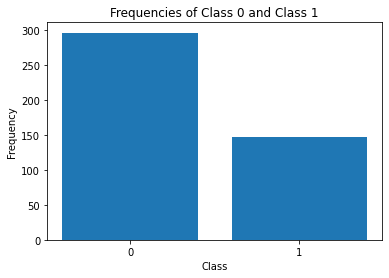

In [9]:
import matplotlib.pyplot as plt

# Count the frequencies of 0s and 1s in the predictions dictionary
freq_0 = sum(value == 0 for value in predictions_dict.values())
freq_1 = sum(value == 1 for value in predictions_dict.values())

# Plot the frequencies
labels = ['0', '1']
frequencies = [freq_0, freq_1]

plt.bar(labels, frequencies)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequencies of Class 0 and Class 1')
plt.show()

In [49]:
indexes = [int(mamada) for mamada in list(predictions_dict.keys())]
no_sorted = indexes
indexes.sort()

for i in range(len(no_sorted)):
    if no_sorted[i] == indexes[i]:
        ola = 0
    else:
        print("FEO")

predictions_dict_sorted = {}
for index in indexes:
    predictions_dict_sorted[str(index)] = predictions_dict[str(index)]
    
index_list = list(predictions_dict_sorted.keys())

['10113',
 '10165',
 '10287',
 '10443',
 '10532',
 '10708',
 '10760',
 '11066',
 '11105',
 '11224',
 '11531',
 '11607',
 '12073',
 '12129',
 '12207',
 '12515',
 '12539',
 '12641',
 '12733',
 '12799',
 '12847',
 '12886',
 '12947',
 '13300',
 '13593',
 '13740',
 '14208',
 '14269',
 '14408',
 '14445',
 '14828',
 '14891',
 '15022',
 '15256',
 '15673',
 '15873',
 '16114',
 '16173',
 '16478',
 '16514',
 '16751',
 '17024',
 '17078',
 '17223',
 '17516',
 '17590',
 '17700',
 '17930',
 '18381',
 '18382',
 '18797',
 '19000',
 '19054',
 '19344',
 '19438',
 '19499',
 '19999',
 '20095',
 '20113',
 '20425',
 '20496',
 '20534',
 '20586',
 '21069',
 '21300',
 '21529',
 '21659',
 '22011',
 '22155',
 '22171',
 '22186',
 '22700',
 '22764',
 '22798',
 '22935',
 '23204',
 '23244',
 '23635',
 '23784',
 '24189',
 '24619',
 '24639',
 '24668',
 '24831',
 '25159',
 '25271',
 '25319',
 '25432',
 '26225',
 '26930',
 '27391',
 '27797',
 '28024',
 '28215',
 '28395',
 '28757',
 '29545',
 '29962',
 '30096',
 '30517',


In [53]:
import json

#predictions_list = [{"index": sample_id, "prediction": prediction} for sample_id, prediction in predictions_dict.items()]

jason = open('submission.json', 'w')
jason.write('[\n')
for i in range(len(index_list)-1):
    jason.write('    {"index": '+ str(index_list[i])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[i]])+ "},")
    jason.write('\n')
jason.write('    {"index": '+ str(index_list[-1])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[-1]])+ "}")
jason.write('\n]')
jason.close()

In [54]:
import json

#predictions_list = [{"index": sample_id, "prediction": prediction} for sample_id, prediction in predictions_dict.items()]

jason = open('submission.json', 'w')
for i in range(len(index_list)-1):
    jason.write('{"index": '+ str(index_list[i])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[i]])+ "}")
    jason.write('\n')
jason.write('{"index": '+ str(index_list[-1])+ ', "prediction": '+ str(predictions_dict_sorted[index_list[-1]])+ "}")
jason.close()

In [ ]:
#Important dictionaries to feed the vectorizers and classificators:

training_text_dict = {}
training_label_dict = {}
for column, row in training_data.iterrows():
    training_text_dict[row['Sample']] = row['Text']
    training_label_dict[row['Sample']] = row['Label']
    
test_text_dict = {}
for column, row in test_data.iterrows():
    test_text_dict[row['Sample']] = row['Text']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

def SVM(X, y, cv, c, kern, gam):
    svm_classifier = SVC(
        probability=True, #probability=True for ensemble learning stuff
        C=c,
        kernel=kern,
        gamma=gam
    )
    accuracy_scores = cross_val_score(svm_classifier, X, y, cv=cv, scoring='accuracy')
    f1_scorer_pos = make_scorer(f1_score, average='binary', pos_label=1)
    f1_scorer_neg = make_scorer(f1_score, average='binary', pos_label=0)
    f1_scores_pos = cross_val_score(svm_classifier, X, y, cv=cv, scoring=f1_scorer_pos)
    f1_scores_neg = cross_val_score(svm_classifier, X, y, cv=cv, scoring=f1_scorer_neg)
    svm_accuracy = accuracy_scores.mean()
    svm_f1_pos = f1_scores_pos.mean()
    svm_f1_neg = f1_scores_neg.mean()
    svm_classifier.fit(X, y)
    return svm_classifier, svm_accuracy, svm_f1_pos, svm_f1_neg

def KNN(X, y, cv, neighs, wei, algo, pe):
    knn_classifier = KNeighborsClassifier(
        n_neighbors=neighs,
        weights=wei,
        algorithm=algo,
        p=pe
    )
    accuracy_scores = cross_val_score(knn_classifier, X, y, cv=cv, scoring='accuracy')
    f1_scorer_pos = make_scorer(f1_score, average='binary', pos_label=1)
    f1_scorer_neg = make_scorer(f1_score, average='binary', pos_label=0)
    f1_scores_pos = cross_val_score(knn_classifier, X, y, cv=cv, scoring=f1_scorer_pos)
    f1_scores_neg = cross_val_score(knn_classifier, X, y, cv=cv, scoring=f1_scorer_neg)
    knn_accuracy = accuracy_scores.mean()
    knn_f1_pos = f1_scores_pos.mean()
    knn_f1_neg = f1_scores_neg.mean()
    knn_classifier.fit(X, y)
    return knn_classifier, knn_accuracy, knn_f1_pos, knn_f1_neg

def LogReg(X, y, cv):
    lr_classifier = LogisticRegression()
    accuracy_scores = cross_val_score(lr_classifier, X, y, cv=cv, scoring='accuracy')
    f1_scorer_pos = make_scorer(f1_score, average='binary', pos_label=1)
    f1_scorer_neg = make_scorer(f1_score, average='binary', pos_label=0)
    f1_scores_pos = cross_val_score(lr_classifier, X, y, cv=cv, scoring=f1_scorer_pos)
    f1_scores_neg = cross_val_score(lr_classifier, X, y, cv=cv, scoring=f1_scorer_neg)
    lr_accuracy = accuracy_scores.mean()
    lr_f1_pos = f1_scores_pos.mean()
    lr_f1_neg = f1_scores_neg.mean()
    lr_classifier.fit(X, y)
    return lr_classifier, lr_accuracy, lr_f1_pos, lr_f1_neg

def DecTree(X, y, rnd, cv):
    clf_classifier = DecisionTreeClassifier(random_state=rnd)
    accuracy_scores = cross_val_score(clf_classifier, X, y, cv=cv, scoring='accuracy')
    f1_scorer_pos = make_scorer(f1_score, average='binary', pos_label=1)
    f1_scorer_neg = make_scorer(f1_score, average='binary', pos_label=0)
    f1_scores_pos = cross_val_score(clf_classifier, X, y, cv=cv, scoring=f1_scorer_pos)
    f1_scores_neg = cross_val_score(clf_classifier, X, y, cv=cv, scoring=f1_scorer_neg)
    clf_accuracy = accuracy_scores.mean()
    clf_f1_pos = f1_scores_pos.mean()
    clf_f1_neg = f1_scores_neg.mean()
    clf_classifier.fit(X, y)
    return clf_classifier, clf_accuracy, clf_f1_pos, clf_f1_neg

def MLP(X, y, hlayers, act, solv, alph, lrate, cv):
    mlp_classifier = MLPClassifier(
        hidden_layer_sizes=hlayers,
        activation=act,
        solver=solv,
        alpha=alph,
        learning_rate=lrate
    )
    accuracy_scores = cross_val_score(mlp_classifier, X, y, cv=cv, scoring='accuracy')
    f1_scorer_pos = make_scorer(f1_score, average='binary', pos_label=1)
    f1_scorer_neg = make_scorer(f1_score, average='binary', pos_label=0)
    f1_scores_pos = cross_val_score(mlp_classifier, X, y, cv=cv, scoring=f1_scorer_pos)
    f1_scores_neg = cross_val_score(mlp_classifier, X, y, cv=cv, scoring=f1_scorer_neg)
    mlp_accuracy = accuracy_scores.mean()
    mlp_f1_pos = f1_scores_pos.mean()
    mlp_f1_neg = f1_scores_neg.mean()
    mlp_classifier.fit(X, y)
    return mlp_classifier, mlp_accuracy, mlp_f1_pos, mlp_f1_neg

cv = 5
X_train = training_both
X_test = test_both
y_train = training_label
y_test = test_label